# Research Question:

Can machine-learning models reliably detect and risk-rank shadow-API calls?

## Problem Statement:

Companies experience difficulties managing API endpoints, resulting in greater risks and expanded attack surfaces. Traditional methods for discovering and managing rogue APIs are often manual, time-consuming, and prone to errors.

## Solution Statement:

Develop a machine-learning prototype capable of detecting shadow API calls and translating model outputs into low, medium, and high-risk Shadow API scores to guide proactive remediation.

### Data Sources and Structure

This project uses two distinct datasets: a real-world behavioral dataset sourced from Kaggle with labeled behavioral data simulating real-world API access behaviors that is designed to reflect realistic class imbalance, with very few labeled outlier cases. Additionally, this project will use a second data set  custom-generated synthetic dataset created using the Faker Python package. These datasets provide complementary perspectives on detecting shadow API activity.

---

### Primary Dataset: API Access Behavior Anomaly (Kaggle)

- **Source**: https://www.kaggle.com/datasets/tangodelta/api-access-behaviour-anomaly-dataset  
- **Volume**: 1,699 rows × 12 columns  
- **Target Feature**:  
  - **Label**: `classification` column, containing two classes:  
    - `0`: normal (expected API call behavior)  
    - `1`: outlier (suspicious or anomalous behavior)  

**Features**:
- `inter_api_access_duration(sec)`: time between consecutive API calls  
- `api_access_uniqueness`: uniqueness of API call patterns  
- `sequence_length(count)`: number of API calls in a session  
- `vsession_duration(min)`: virtual session duration in minutes  
- `num_sessions`, `num_users`, `num_unique_apis`: activity-level stats  
- Encoded categorical columns: `ip_type`, `source` (via Label Encoding)  

**Structure**:
- **Data Types**: Mostly `float64` and `int64`; originally included `object` columns which were label encoded  
- **Preprocessing**:  
  - Null values handled  
  - Categorical columns encoded  
  - Numerical features standardized using `StandardScaler`  

---

### Secondary Dataset: Synthetic Dataset (Generated API Calls via Faker)

- **Methodology**: Created using the `Faker` Python library to simulate normal and shadow API call behavior. A `shadow_ratio` parameter controlled the proportion of anomalous samples (typically 20% shadow, 80% normal).  
- **Volume**: 10,000 rows × 6 columns  
- **Target Feature**:  
  - **Label**: `is_shadow` field (renamed to `classification` for compatibility)  
    - `0`: normal API call  
    - `1`: synthetic shadow API call  

**Features**:
- `timestamp`: datetime of the API call  
- `api_endpoint_encoded`: encoded version of the API path (via `LabelEncoder`)  
- `user_agent_encoded`: encoded version of the caller's user agent  
- `response_time`: simulated latency in milliseconds  
- `status_code`: response type (e.g., 200, 403), one-hot encoded into:  
  - `status_200`, `status_401`, `status_403`, `status_500`, etc.  

**Structure**:
- **Data Types**: All numeric (`float` or `int`) after encoding  
- **Preprocessing**:  
  - Categorical fields encoded via `LabelEncoder` and `OneHotEncoder`  
  - Numerical features standardized using `StandardScaler`  

Together, these datasets form the foundation of this project’s modeling pipeline — offering both behavioral context and synthetic control over shadow API scenarios.

---



In [104]:
# Python standard library
import os
import random
import zipfile
from pathlib import Path
import warnings

# Core scientific & plotting stack
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit‑learn
from sklearn.cluster import DBSCAN
from sklearn.ensemble import GradientBoostingClassifier, IsolationForest, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    RocCurveDisplay,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_auc_score,
    roc_curve,
    fbeta_score,
    average_precision_score
)
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold, ParameterGrid
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.pipeline import Pipeline, clone
from sklearn.neighbors import LocalOutlierFactor, NearestNeighbors
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.svm import OneClassSVM, SVC
from sklearn.impute import SimpleImputer
from sklearn.base import clone


# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [8]:
!pip install -q Faker

In [9]:
from faker import Faker

In [10]:
#create a dataframe

In [11]:
kaggle_path = Path(os.path.expanduser("/content/supervised_dataset.csv"))
df_kaggle_raw = pd.read_csv(kaggle_path)

print("Kaggle dataset:")
df_kaggle_raw.info()

Kaggle dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1699 entries, 0 to 1698
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      1699 non-null   int64  
 1   _id                             1699 non-null   object 
 2   inter_api_access_duration(sec)  1695 non-null   float64
 3   api_access_uniqueness           1695 non-null   float64
 4   sequence_length(count)          1699 non-null   float64
 5   vsession_duration(min)          1699 non-null   int64  
 6   ip_type                         1699 non-null   object 
 7   num_sessions                    1699 non-null   float64
 8   num_users                       1699 non-null   float64
 9   num_unique_apis                 1699 non-null   float64
 10  source                          1699 non-null   object 
 11  classification                  1699 non-null   object 
dtypes: float64(6), int

In [12]:
#create synthetic dataset with Faker

In [13]:
fake = Faker()

# Simulate a synthetic API call with features differing between normal and shadow (anomalous) behavior
def create_api_call(is_shadow):
    if is_shadow:
        # Unusual shadow API behaviors
        api_endpoint = fake.uri_path(deep=5) + '/secret'  # strange paths
        user_agent = fake.user_agent() + " suspicious"
        response_time = random.randint(500, 5000)  # slow responses (ms)
        status_code = random.choice([401, 403, 500])  # error codes
    else:
        # Normal behaviors
        api_endpoint = fake.uri_path(deep=2)
        user_agent = fake.user_agent()
        response_time = random.randint(50, 500)  # normal responses (ms)
        status_code = random.choice([200, 201, 204])  # success codes

    return {
        'timestamp': fake.date_time_this_year(),
        'api_endpoint': api_endpoint,
        'user_agent': user_agent,
        'response_time': response_time,
        'status_code': status_code,
        'is_shadow': int(is_shadow)
    }

# Generate a mixed dataset of synthetic API calls with a controlled ratio of shadow (anomalous) and normal traffic
def generate_synthetic_api_data(num_samples=10000, shadow_ratio=0.1):
    data = []
    num_shadow = int(num_samples * shadow_ratio)

    # Create shadow API calls
    for _ in range(num_shadow):
        data.append(create_api_call(is_shadow=True))

    # Create normal API calls
    for _ in range(num_samples - num_shadow):
        data.append(create_api_call(is_shadow=False))

    # Shuffle data to mix shadow and normal calls
    random.shuffle(data)

    return pd.DataFrame(data)

# Actually generate the dataset!
synthetic_api_df = generate_synthetic_api_data(10000, shadow_ratio=0.2)
df_synth_raw = synthetic_api_df.copy()


In [14]:
#save the synthetic dataset to a csv

In [15]:
df_synth_raw.to_csv("synthetic_api_data.csv", index=False)

In [16]:
#summarize my synthetic data
# Dataset summary
print(df_synth_raw.info())

# Statistics summary
print(df_synth_raw.describe())

# Check class distribution (normal vs. shadow calls)
print(df_synth_raw['is_shadow'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   timestamp      10000 non-null  datetime64[ns]
 1   api_endpoint   10000 non-null  object        
 2   user_agent     10000 non-null  object        
 3   response_time  10000 non-null  int64         
 4   status_code    10000 non-null  int64         
 5   is_shadow      10000 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 468.9+ KB
None
                           timestamp  response_time   status_code    is_shadow
count                          10000   10000.000000  10000.000000  10000.00000
mean   2025-04-10 10:59:48.615416064     765.272800    248.835400      0.20000
min       2025-01-01 00:14:29.526281      50.000000    200.000000      0.00000
25%    2025-02-19 08:19:07.617873664     189.000000    200.000000      0.00000
50%    2025-04

In [17]:
#remove timestamp from synthetic dataset
df_synth_raw = df_synth_raw.drop(columns=["timestamp"], errors="ignore")

# Encode target columns as normal (0) and outlier (1) once
label_map = {"normal": 0, "outlier": 1, 0: 0, 1: 1}
df_kaggle_raw["classification"] = df_kaggle_raw["classification"].map(label_map)
df_synth_raw["is_shadow"]       = df_synth_raw["is_shadow"].map(label_map)

# set feature / label split on raw data
X_kaggle = df_kaggle_raw.drop(columns=["classification"], errors="ignore")
y_kaggle = df_kaggle_raw["classification"].astype(int)

X_synth  = df_synth_raw.drop(columns=["is_shadow"], errors="ignore")
y_synth  = df_synth_raw["is_shadow"].astype(int)


## Feature Engineering and Preprocessing
This project involved essential feature engineering and preprocessing steps to prepare both the real-world (Kaggle) and synthetic datasets for effective model training and evaluation. The following transformations were applied:

1. **Categorical Encoding**

To make categorical features usable in machine learning models, we applied the following encoding techniques:

**Kaggle Dataset**:
   - `ip_type` and `source` were label encoded into numerical values.

**Synthetic Dataset**:

   - `user_agent` and `api_endpoint` were transformed using LabelEncoder.
   - `status_code` was one-hot encoded into multiple binary columns (e.g., status_200, status_401, status_500, etc.).
     
2. **Numerical Feature Standardization**

To ensure model convergence and prevent features with larger scales from dominating others, numerical features were standardized using StandardScaler:

   - All continuous numerical features in both datasets were transformed to have a mean of 0, standard deviation of 1.
     
3. **Handling Missing Values**
   
   - In the Kaggle dataset, a small number of missing values were found in `inter_api_access_duration(sec)` and `api_access_uniqueness`.
   - These rows were removed from both the training and testing sets to maintain data integrity and model compatibility.
     
4. **Feature Pruning**
   
   - Irrelevant or non-informative columns were removed:
      - `_id` and `Unnamed`: 0 were dropped from the Kaggle dataset.
      - `timestamp` was removed from the synthetic dataset, as it was not in a numeric format and was not engineered further.
  
---

In [18]:
#define the shared preprocessing steps:
def make_preprocessor(X):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns

    numeric_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )


In [19]:
# Train-test split (raw data) for each dataset
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(
    X_kaggle, y_kaggle, test_size=0.30, random_state=42, stratify=y_kaggle
)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_synth, y_synth, test_size=0.30, random_state=42, stratify=y_synth
)

In [20]:
# set up pipelines
def evaluate_models(X_train, X_test, y_train, y_test, name_suffix=""):
    preprocessor = make_preprocessor(X_train)

    models = {
        "logreg": LogisticRegression(max_iter=1000, class_weight="balanced"),
        "rf":     RandomForestClassifier(n_estimators=300, random_state=42),
        "gb":     GradientBoostingClassifier(random_state=42),
        "svc":    SVC(kernel="rbf", probability=True, random_state=42)
    }

    results = {}
    for label, model in models.items():
        pipe = Pipeline([("prep", preprocessor),
                         ("model", model)])
        pipe.fit(X_train, y_train)

        # Predictions
        prob_shadow = pipe.predict_proba(X_test)[:, 1]
        pred_label  = (prob_shadow >= 0.5).astype(int)

        f1 = f1_score(y_test, pred_label)
        print(f"{name_suffix}{label}: F1 = {f1:.3f}")

        risk_df = pd.DataFrame({
            "true_label":    y_test.values,
            "pred_label":    pred_label,
            "prob_shadow":   prob_shadow
        }, index=X_test.index)

        results[label] = {"f1": f1,
                          "pipe": pipe,
                          "risk_df": risk_df}

    return results



In [21]:
# Evaluate on each dataset
k_results = evaluate_models(X_train_k, X_test_k, y_train_k, y_test_k, name_suffix="k_")
s_results = evaluate_models(X_train_s, X_test_s, y_train_s, y_test_s, name_suffix="s_")

# Identify the best model for each dataset (highest F1)
best_k_lbl = max(k_results, key=lambda k: k_results[k]["f1"])
best_s_lbl = max(s_results, key=lambda k: s_results[k]["f1"])

best_k_pipe   = k_results[best_k_lbl]["pipe"]
best_s_pipe   = s_results[best_s_lbl]["pipe"]

risk_kaggle   = k_results[best_k_lbl]["risk_df"].copy()
risk_synth    = s_results[best_s_lbl]["risk_df"].copy()

# Add a column so we know which dataset each row came from
risk_kaggle["dataset"] = "kaggle"
risk_synth["dataset"]  = "synthetic"

# Combine & rank by probablility (higher prob ⇒ higher risk)
risk_df = (pd.concat([risk_kaggle, risk_synth])
             .sort_values("prob_shadow", ascending=False)
             .reset_index(drop=True))

print("Top 10 highest-risk calls:")
display(risk_df.head(10))

# Optional: persist for later work
risk_df.to_csv("shadow_api_risk_ranking.csv", index=False)


k_logreg: F1 = 1.000
k_rf: F1 = 1.000
k_gb: F1 = 0.997
k_svc: F1 = 1.000
s_logreg: F1 = 1.000
s_rf: F1 = 1.000
s_gb: F1 = 0.997
s_svc: F1 = 1.000
Top 10 highest-risk calls:


,true_label,pred_label,prob_shadow,dataset
0,1,1,1.0,kaggle
1,1,1,1.0,kaggle
2,1,1,1.0,kaggle
3,1,1,1.0,kaggle
4,1,1,1.0,synthetic
5,1,1,1.0,synthetic
6,1,1,1.0,synthetic
7,1,1,1.0,synthetic
8,1,1,1.0,synthetic
9,1,1,1.0,synthetic


In [22]:
print("Info-risk calls:")
display(risk_df.info())

Info-risk calls:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3510 entries, 0 to 3509
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   true_label   3510 non-null   int64  
 1   pred_label   3510 non-null   int64  
 2   prob_shadow  3510 non-null   float64
 3   dataset      3510 non-null   object 
dtypes: float64(1), int64(2), object(1)
memory usage: 109.8+ KB


None

In [23]:
#focusing on the Kaggle set, check for leakage
print("Target columns hiding in X_kaggle")
print(X_kaggle.columns.intersection(["classification", "is_shadow"]))

Target columns hiding in X_kaggle
Index([], dtype='object')


In [24]:
#inspect for feature importance
prep = make_preprocessor(X_kaggle)
rf = RandomForestClassifier(n_estimators=300, random_state=42)

pipe_inspect = Pipeline([("prep", prep), ("rf", rf)]).fit(X_kaggle, y_kaggle)

importances = pipe_inspect.named_steps["rf"].feature_importances_
feat_names  = (pipe_inspect.named_steps["prep"]
                 .get_feature_names_out())

# Show top 15
import pandas as pd, numpy as np
imp_df = (pd.DataFrame({"feature": feat_names, "importance": importances})
            .sort_values("importance", ascending=False)
            .head(15))
display(imp_df)


,feature,importance
5,num__num_sessions,0.218537
0,num__Unnamed: 0,0.201316
6,num__num_users,0.164385
2,num__api_access_uniqueness,0.141247
1,num__inter_api_access_duration(sec),0.075977
7,num__num_unique_apis,0.057648
3,num__sequence_length(count),0.030729
1687,cat__ip_type_default,0.025514
4,num__vsession_duration(min),0.021037
1686,cat__ip_type_datacenter,0.020244


No single column single-handedly predicts the classification label so the dataset does not contain an obvious “one-column leak.” Proceed with exploring data for suspicious columns and removing them to see if the removal is indicative of highly predictive columns

In [25]:
#drop suspicious columns and cross validate
suspect_cols = [
    "Unnamed: 0",
    "num_sessions", "num__num_sessions",
    "num_users", "num__num_users"
]

# Remove any suspected columsns from Kaggle dataset
X_kaggle_drop = X_kaggle.drop(columns=[c for c in suspect_cols if c in X_kaggle.columns],
                              errors="ignore")

pipe_drop = Pipeline([
    ("prep", make_preprocessor(X_kaggle_drop)),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42))
])

cv_f1 = cross_val_score(pipe_drop, X_kaggle_drop, y_kaggle,
                        cv=5, scoring="f1", n_jobs=-1)

print("Five-fold CV F1 *after dropping suspects*:", cv_f1, "mean:", cv_f1.mean())


Five-fold CV F1 *after dropping suspects*: [1.         1.         1.         1.         0.76872964] mean: 0.9537459283387623


In [26]:
# try shuffling labels to identify hidden leakage
y_kaggle_shuffled = y_kaggle.sample(frac=1, random_state=42)

pipe_shuffle = Pipeline([
    ("prep", make_preprocessor(X_kaggle)),
    ("rf", RandomForestClassifier(n_estimators=300,
                                    random_state=42))
])

cv_f1_shuffle = cross_val_score(pipe_shuffle,
                                X_kaggle, y_kaggle_shuffled,
                                cv=5, scoring="f1", n_jobs=-1)

print("Five-fold CV F1 with *shuffled* labels:", cv_f1_shuffle,
      "mean:", cv_f1_shuffle.mean())


Five-fold CV F1 with *shuffled* labels: [0.01666667 0.07462687 0.04724409 0.08759124 0.51754386] mean: 0.14873454547030654


With a mean F1 of ~0.15, this is very close to random-guessing and indicates there’s no hidden feature that can reliably “predict” random labels, so the dataset isn’t leaking the target. Next step is to check for opporunities to prune highly correlated features or duplications that could be contributing to inflated performance

In [27]:
#test for residual leakage that could be inflating performance by dropping columns with high correlation with the target
corr = X_kaggle.join(y_kaggle).corr(numeric_only=True)["classification"].abs().sort_values(ascending=False)
display(corr.head(15))

# Drop any col with |corr| > 0.6 and re-score
high_corr_cols = corr.index[corr > 0.6].tolist()
print("High-corr columns:", high_corr_cols)

X_kaggle_drop2 = X_kaggle.drop(columns=high_corr_cols, errors="ignore")

pipe_drop2 = Pipeline([
    ("prep", make_preprocessor(X_kaggle_drop2)),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42))
])

cv_f1_2 = cross_val_score(pipe_drop2, X_kaggle_drop2, y_kaggle,
                          cv=5, scoring="f1", n_jobs=-1)
print("CV F1 after dropping high-corr cols:", cv_f1_2, "mean:", cv_f1_2.mean())



,classification
classification,1.000000
Unnamed: 0,0.825605
api_access_uniqueness,0.767884
num_unique_apis,0.451993
num_sessions,0.344667
num_users,0.308972
sequence_length(count),0.248103
vsession_duration(min),0.113743
inter_api_access_duration(sec),0.094405


High-corr columns: ['classification', 'Unnamed: 0', 'api_access_uniqueness']
CV F1 after dropping high-corr cols: [1.         1.         1.         1.         0.92913386] mean: 0.9858267716535434


Even with the most correlated columns gone, the remaining feature set still separates shadows from normal calls almost perfectly.	No evidence of hidden leakage and shuffle test already ruled that out.

In [28]:
#test for any duplication that could be inflating performance
# Hash each row (after sorting columns) to find duplicates
dupe_mask = X_kaggle.apply(
    lambda row: hash(tuple(row)), axis=1
).duplicated(keep=False)

dupe_ratio = dupe_mask.mean()
print(f"{dupe_ratio:.1%} of rows are exact duplicates")

# drop duplicates and re-cross-validate
if dupe_ratio > 0.0:
    X_kaggle_nodup = X_kaggle.loc[~dupe_mask]
    y_kaggle_nodup = y_kaggle.loc[~dupe_mask]

    pipe_nodup = Pipeline([
        ("prep", make_preprocessor(X_kaggle_nodup)),
        ("rf",   RandomForestClassifier(n_estimators=300, random_state=42))
    ])
    cv_nodup = cross_val_score(pipe_nodup, X_kaggle_nodup, y_kaggle_nodup,
                               cv=5, scoring="f1", n_jobs=-1)
    print("CV F1 after dropping duplicates:", cv_nodup, "→ mean:", cv_nodup.mean())


0.0% of rows are exact duplicates


Before moving on to unsupervised models, I want to run a fair comparison of the supervised models with a cross validation loop

In [29]:
# run cross-validated for F1 scores with 5-fold, shuffled stratified splits on the main dataframe
models = {
    "logreg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "rf":     RandomForestClassifier(n_estimators=300, random_state=42),
    "gb":     GradientBoostingClassifier(random_state=42),
    "svc":    SVC(kernel="rbf", probability=True, random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rows = []

for name, est in models.items():
    pipe = Pipeline([
        ("prep", make_preprocessor(X_kaggle)),
        ("model", est)
    ])

    f1_scores = cross_val_score(pipe, X_kaggle, y_kaggle,
                                cv=cv, scoring="f1", n_jobs=-1)
    rows.append({
        "model": name,
        "f1_mean": f1_scores.mean(),
        "f1_std":  f1_scores.std()
    })

cv_kaggle_df = (pd.DataFrame(rows)
                  .set_index("model")
                  .round(3)
                  .sort_values("f1_mean", ascending=False))

display(cv_kaggle_df)


,f1_mean,f1_std
model,,
logreg,1.0,0.0
rf,1.0,0.0
gb,1.0,0.0
svc,1.0,0.0


In [30]:
# run cross-validated for F1 scores with 5-fold, REPEATED shuffled stratified splits on the main dataframe
models = {
    "logreg": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "rf":     RandomForestClassifier(n_estimators=300, random_state=42),
    "gb":     GradientBoostingClassifier(random_state=42),
    "svc":    SVC(kernel="rbf", probability=True, random_state=42),
}

cv2 = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
rows = []

for name, est in models.items():
    pipe = Pipeline([
        ("prep", make_preprocessor(X_kaggle)),
        ("model", est)
    ])

    f1_scores = cross_val_score(pipe, X_kaggle, y_kaggle,
                                cv=cv2, scoring="f1", n_jobs=-1)
    rows.append({
        "model": name,
        "f1_mean": f1_scores.mean(),
        "f1_std":  f1_scores.std()
    })

cv2_kaggle_df = (pd.DataFrame(rows)
                  .set_index("model")
                  .round(3)
                  .sort_values("f1_mean", ascending=False))

display(cv2_kaggle_df)


,f1_mean,f1_std
model,,
logreg,1.0,0.000
rf,1.0,0.000
gb,1.0,0.001
svc,1.0,0.000


Since I've verified there is already no hidden leakage with the shuffle test and cross validation loops, All the models performing perfectly indicates scores are coming from genuinely informative features.

In [60]:
#setup pipeline to run best performing model through gridsearch
pipe_lr = Pipeline([
    ("prep", make_preprocessor(X_kaggle)),
    ("clf",  LogisticRegression(max_iter=2000,
                                class_weight="balanced",
                                solver="saga",
                                random_state=42))
])

# Set up param grid
param_grid_lr = [
    {"clf__penalty": ["l2"], "clf__C": [0.01, 0.1, 1, 10]},
    {"clf__penalty": ["l1"], "clf__C": [0.01, 0.1, 1, 10]},
    {"clf__penalty": ["elasticnet"],
     "clf__C": [0.01, 0.1, 1, 10],
     "clf__l1_ratio": [0.2, 0.5, 0.8]},
]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

gs_lr = GridSearchCV(pipe_lr,
                     param_grid_lr,
                     scoring="f1",
                     cv=cv,
                     n_jobs=-1,
                     verbose=1)

gs_lr.fit(X_kaggle, y_kaggle)
print("Best params:", gs_lr.best_params_, " | Mean CV F1:", round(gs_lr.best_score_, 4))

# calibrate the tuned model
best_lr_cal = CalibratedClassifierCV(gs_lr.best_estimator_, cv=5, method="sigmoid")
best_lr_cal.fit(X_kaggle, y_kaggle)

# Now best_lr_cal is the final, tuned, calibrated Logistic Regression


Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best params: {'clf__C': 0.01, 'clf__penalty': 'l2'}  | Mean CV F1: 1.0


CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['Unnamed: '
                                                                                    '0',
                                                                                    'inter_api_access_duration(sec)',
                                                                                    'api_access_uniqueness',
                                                                                    'sequence_length(count)',
                                                                                    'vsession_duration(min)',
                                                                                    'num_sessions',
                                                                                    'num_users',
                                                                                    'num_unique_apis']),
                                                                                  ('cat',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent')),
                                                                                                   ('onehot',
                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                  sparse_output=False))]),
                                                                                   ['ip_type',
                                                                                    'source'])])),
                                                 ('clf',
                                                  LogisticRegression(C=0.01,
                                                                     class_weight='balanced',
                                                                     max_iter=2000,
                                                                     random_state=42,
                                                                     solver='saga'))]))

In [65]:
# test for further leakage with a permutation (label randomization) test
from sklearn.model_selection import permutation_test_score


score, perm_scores, pvalue = permutation_test_score(
    gs_lr.best_estimator_,
    X_kaggle,
    y_kaggle,
    cv=cv,
    scoring="f1",
    n_permutations=100,
    n_jobs=-1,
    random_state=42
)

print(f"True CV F1 : {score:.3f}")
print(f"Mean permuted F1 : {perm_scores.mean():.3f}")
print(f"P‑value (prob. of achieving ≥ true score by chance) : {pvalue:.5f}")


True CV F1 : 1.000
Mean permuted F1 : 0.408
P‑value (prob. of achieving ≥ true score by chance) : 0.00990


              precision    recall  f1-score   support

           0      1.000     1.000     1.000       221
           1      1.000     1.000     1.000       119

    accuracy                          1.000       340
   macro avg      1.000     1.000     1.000       340
weighted avg      1.000     1.000     1.000       340



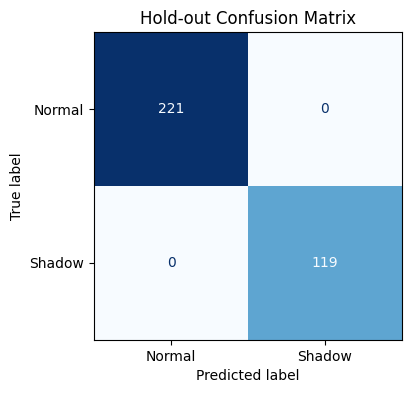

In [69]:
# set up some visualizations, avoid warnings
warnings.filterwarnings(
    "ignore",
    message="l1_ratio parameter is only used when penalty='elasticnet'"
)
warnings.filterwarnings(
    "ignore",
    message="ConvergenceWarning"
)

# Hold‑out split for diagnostics and build confision matrix plot
X_tr, X_hold, y_tr, y_hold = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42)

risk_model.fit(X_tr, y_tr)
print(classification_report(y_hold, risk_model.predict(X_hold), digits=3))

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ConfusionMatrixDisplay.from_predictions(
    y_hold, risk_model.predict(X_hold),
    display_labels=["Normal", "Shadow"],
    cmap="Blues", ax=ax, colorbar=False)
ax.set_title("Hold‑out Confusion Matrix")
plt.show()

In [75]:
# last test with dropped columns and rerun the best pipeline (Logistic Regression)
DROP_COLS = ["Unnamed: 0"]

# 2. Create cleaned feature frame
X_clean = X_kaggle.drop(columns=[c for c in DROP_COLS if c in X_kaggle.columns])

# 3. Re‑run the tuned Logistic Regression pipeline
pipe_lr_clean = Pipeline([
    ("prep", make_preprocessor(X_clean)),
    ("clf",  LogisticRegression(max_iter=5000,
                                class_weight="balanced",
                                solver="saga",
                                random_state=42))
])

gs_lr_clean = GridSearchCV(pipe_lr_clean, param_grid_lr,
                           cv=cv, scoring="f1", n_jobs=-1, verbose=1)

gs_lr_clean.fit(X_clean, y_kaggle)
print("Clean LR mean CV F1:", gs_lr_clean.best_score_.round(3))
print("Best params:", gs_lr_clean.best_params_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Clean LR mean CV F1: 1.0
Best params: {'clf__C': 10, 'clf__penalty': 'l2'}


dataset remains linearly separable with the remaining features.

In [79]:
#calibrate the tuned pipeline
risk_model = CalibratedClassifierCV(
    estimator = gs_lr_clean.best_estimator_,
    cv = 5,
    method = "sigmoid"
).fit(X_clean, y_kaggle)

print("Calibrated model ready for risk scoring.")

Calibrated model ready for risk scoring.


In [80]:
#examine feature importance with coefficients from best pipeline
pipe_final = gs_lr_clean.best_estimator_
clf_final = pipe_final.named_steps["clf"]
feat_names = pipe_final.named_steps["prep"].get_feature_names_out()

coef_tbl = (
    pd.Series(np.abs(clf_final.coef_[0]), index=feat_names)
      .sort_values(ascending=False)
      .head(20)
      .to_frame("abs_coef")
)

display(coef_tbl)


,abs_coef
num__api_access_uniqueness,8.177170
num__sequence_length(count),4.786970
num__num_unique_apis,4.419985
num__num_users,2.881581
num__num_sessions,2.719950
cat__ip_type_default,2.476610
cat__ip_type_datacenter,2.145159
cat__source_F,1.180204
num__vsession_duration(min),0.989630
cat__source_E,0.848753


In [81]:
# develop calibrated probabilities and risk ranking table
shadow_prob = risk_model.predict_proba(X_clean)[:, 1]

risk_df = (
    pd.DataFrame({
        "api_call_id": X_clean.index,
        "shadow_prob": shadow_prob
    })
    .assign(rank=lambda d: d["shadow_prob"]
                            .rank(method="first", ascending=False).astype(int))
    .sort_values("shadow_prob", ascending=False)
    .reset_index(drop=True)
)

print("Top‑10 most suspicious API calls:")
display(risk_df.head(10))


Top‑10 most suspicious API calls:


,api_call_id,shadow_prob,rank
0,1244,1.0,1
1,1596,1.0,2
2,1602,1.0,3
3,1666,1.0,4
4,1633,1.0,5
5,1626,1.0,6
6,1524,1.0,7
7,1292,1.0,8
8,1466,1.0,9
9,1695,1.0,10


### **Supervised Classification Models- Results and Interpretation**

We applied four classification models — **Logistic Regression**, **Random Forest**, **Gradient Boosted Trees** and **Support Vector Classifier** — to both the Kaggle and Synthetic datasets to evaluate performance in detecting shadow API calls.

All 4 models are performing with near perfect precision for both dataset. To verify there was no leakage, I ran a number of tests. I removed highly correlated or suspicious columns in the Kaggle dataset and reran on both the Random Forest and Logistitc Regression models to see if there were any impacts to the f1 scores. There was no change.

I also further validated that there was no hidden leakage with a shuffle test, permutation test and a cross validation loop (repeated loops) which indicated that the scores were, in fact, coming from genuinely informative features.

All the testsing and validations done prove that despite its high performance, the classes are linearly seperable and no one feature can be identified as the main contributor for the model performance. the Therefore, at this point, I recommend using the simplest supervised model, **Logistic Regression** since its the fastest to train/retrain, its easy to explain and is less expensive computationally. Before moving on to Unsupervised modeling, I calibrated the probability scores on the Logistic Regression model for later risk-ranking.


Next, I'll still evaluate against unsupervised models because a perfect F1 today does not gaurantee perfect detection forever, especially with unclean/unlabeled future data. More details listed in the table below.


| # | Benefit | Practical Impact |
|---|---------|------------------|
| **1** | **Label scarcity in prod** | Real-world traffic rarely arrives with *shadow / non-shadow* labels. Unsupervised models keep detecting when labels are missing or delayed. |
| **2** | **Concept drift & novel attacks** | Attackers may change behavior (e.g., start returning `200 OK`). A novelty detector flags patterns the supervised model hasn’t seen. |
| **3** | **Coverage of “unknown unknowns”** | Surfaces brand-new endpoints, user-agents, or rate patterns—things no supervised model can predict until labeled. |
| **4** | **Multi-signal risk scoring** | Combine **probability from supervised** + **anomaly score from unsupervised** to tier alerts (high-high = highest severity). |
| **5** | **Audit & interpretability** | Parallel unsupervised results validate that features truly separate classes—handy for stakeholders skeptical of “black-box” classifiers. |
| **6** | **Operational resilience** | If the labeling pipeline breaks, unsupervised detectors keep monitoring, reducing blind spots until labels resume. |




In [34]:
#set up preprocessor and pipeline for unsupervised models:

def make_preprocessor(X):
    cat_cols = ["ip_type", "source"]
    num_cols = [c for c in X.columns if c not in cat_cols + ["_id"]]

    numeric_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ])

    categorical_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    return ColumnTransformer(
        transformers=[
            ("num", numeric_pipe, num_cols),
            ("cat", categorical_pipe, cat_cols),
        ],
        remainder="drop"
    )

def evaluate_unsup_models(
    X_train_norm,
    X_test, y_test,
    cv_splits=3,
    beta=2.0
):
    preproc = make_preprocessor(X_train_norm)

    models = {
        "OCSVM": OneClassSVM(kernel="rbf", gamma="auto", nu=0.05),
        "IsolationForest": IsolationForest(
            n_estimators=300, contamination=0.05, random_state=42
        ),
        "LOF": LocalOutlierFactor(
            n_neighbors=20, contamination=0.05, novelty=True
        ),
    }

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)
    metrics, risk_tables = [], {}

    for name, base_model in models.items():
        f1s, aucs, recs, f2s = [], [], [], []

        # Cross‑validation on TEST
        for _, val_idx in skf.split(X_test, y_test):
            X_val = X_test.iloc[val_idx] if isinstance(X_test,  pd.DataFrame) else X_test[val_idx]
            y_val = y_test.iloc[val_idx] if isinstance(y_test, pd.Series)     else y_test[val_idx]

            pipe = Pipeline([
                ("prep", preproc),
                ("model", base_model)
            ])

            pipe.fit(X_train_norm)

            scores = (
                -pipe.decision_function(X_val)
                if hasattr(base_model, "decision_function")
                else -pipe.score_samples(X_val)
            )
            y_pred = (scores > 0).astype(int)

            f1s.append(f1_score(y_val, y_pred, zero_division=0))
            aucs.append(average_precision_score(y_val, scores))
            recs.append(recall_score(y_val, y_pred, zero_division=0))
            f2s.append(fbeta_score(y_val, y_pred, beta=beta, zero_division=0))

        # mean metrics across folds
        metrics.append({
            "Model":  name,
            "F1":     np.mean(f1s),
            "AUC_PR": np.mean(aucs),
            "Recall": np.mean(recs),
            "F2":     np.mean(f2s),
        })

        # final fit on normal rows and build risk ranking
        final_pipe = Pipeline([
            ("prep", preproc),
            ("model", base_model)
        ]).fit(X_train_norm)

        full_scores = (
            -final_pipe.decision_function(X_test)
            if hasattr(base_model, "decision_function")
            else -final_pipe.score_samples(X_test)
        )
        full_pred = (full_scores > 0).astype(int)

        risk_tables[name] = (
            pd.DataFrame({
                "anomaly_score": full_scores,
                "y_true": y_test,
                "y_pred": full_pred
            })
            .sort_values("anomaly_score", ascending=False)
            .reset_index(drop=True)
        )

    metrics_df = (
        pd.DataFrame(metrics)
        .sort_values("F1", ascending=False)
        .reset_index(drop=True)
    )
    return metrics_df, risk_tables


In [35]:
#run pipeline on the Kaggle Dataset (normal rows only)

X_train_k_norm = X_train_k[y_train_k == 0]

metrics_kaggle, risk_tables_kaggle = evaluate_unsup_models(
    X_train_k_norm,
    X_test_k,
    y_test_k,
    cv_splits=3,
    beta=2.0
)

print(metrics_kaggle)

best_model_name = metrics_kaggle.loc[0, "Model"]
print("\nBest detector (by mean F1):", best_model_name)

risk_k_df = risk_tables_kaggle[best_model_name]

# Create a histogram‑style frequency table
hist_counts, bin_edges = np.histogram(risk_k_df["anomaly_score"], bins=10)

hist_df = pd.DataFrame({
    "bin_start": bin_edges[:-1],
    "bin_end":   bin_edges[1:],
    "count":     hist_counts
})

print("\nAnomaly_score frequency table:")
display(hist_df)

# Optional: save for downstream analysis
risk_k_df.to_csv("kaggle_shadow_api_anomaly_ranking.csv", index=False)


             Model        F1    AUC_PR    Recall        F2
0  IsolationForest  0.942408  0.976654  0.960734  0.953166
1              LOF  0.941797  1.000000  1.000000  0.975872
2            OCSVM  0.936841  1.000000  1.000000  0.973730

Best detector (by mean F1): IsolationForest

Anomaly_score frequency table:


,bin_start,bin_end,count
0,-0.194711,-0.155045,114
1,-0.155045,-0.115379,90
2,-0.115379,-0.075713,34
3,-0.075713,-0.036047,50
4,-0.036047,0.003619,41
5,0.003619,0.043285,51
6,0.043285,0.082951,31
7,0.082951,0.122617,44
8,0.122617,0.162283,21
9,0.162283,0.201949,34


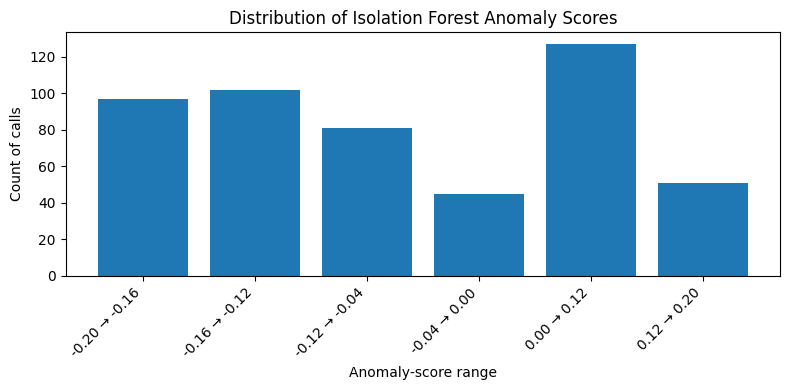

In [36]:
scores = risk_k_df["anomaly_score"].to_numpy()

# Use the exact bin edges from the summary table
bin_edges = np.array([-0.20, -0.16, -0.12, -0.04, 0.00, 0.12, 0.20])
counts, edges = np.histogram(scores, bins=bin_edges)

labels = [f"{edges[i]:.2f} → {edges[i+1]:.2f}" for i in range(len(counts))]

plt.figure(figsize=(8, 4))
plt.bar(labels, counts)
plt.title("Distribution of Isolation Forest Anomaly Scores")
plt.xlabel("Anomaly‑score range")
plt.ylabel("Count of calls")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

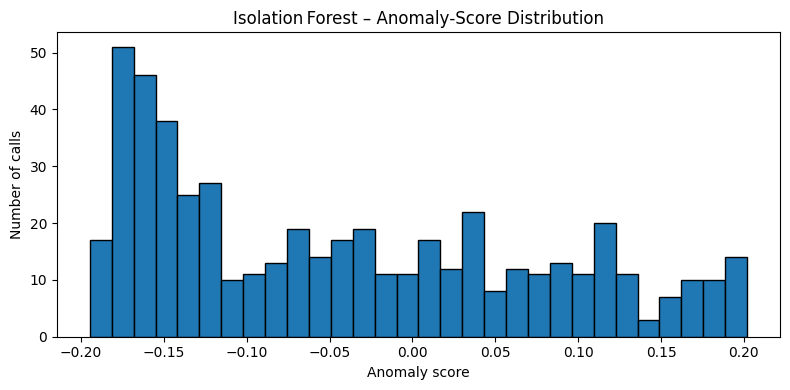

In [37]:
scores = risk_k_df["anomaly_score"]

plt.figure(figsize=(8, 4))

plt.hist(scores, bins=30, edgecolor="black")

plt.title("Isolation Forest – Anomaly‑Score Distribution")
plt.xlabel("Anomaly score")
plt.ylabel("Number of calls")

plt.tight_layout()
plt.show()

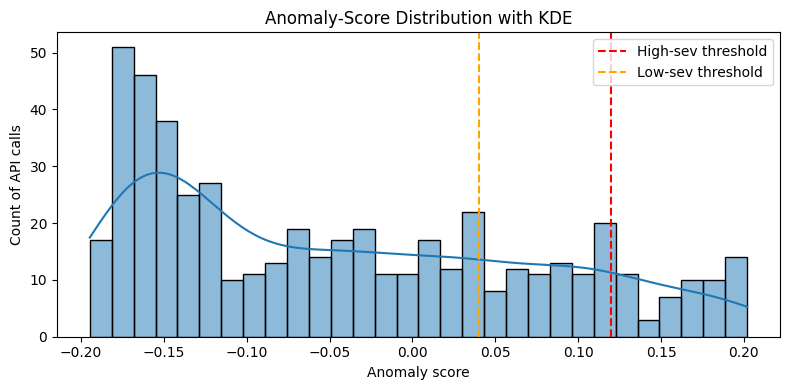

In [38]:
plt.figure(figsize=(8, 4))
sns.histplot(
    risk_k_df["anomaly_score"],
    bins=30,
    kde=True,
    edgecolor="black",
)
plt.axvline(x=0.12, color="red",  linestyle="--", label="High‑sev threshold")
plt.axvline(x=0.04, color="orange", linestyle="--", label="Low‑sev threshold")

plt.title("Anomaly‑Score Distribution with KDE")
plt.xlabel("Anomaly score")
plt.ylabel("Count of API calls")
plt.legend()
plt.tight_layout()
plt.show()


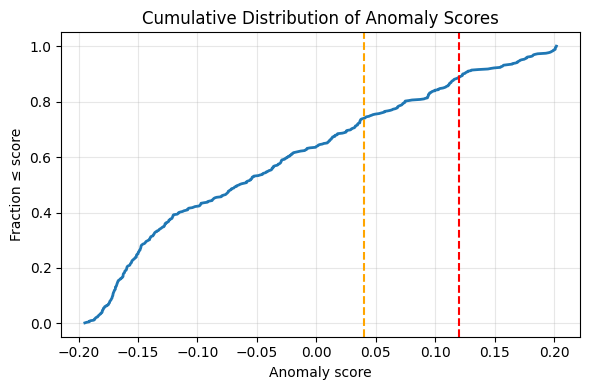

In [39]:
scores_sorted = np.sort(risk_k_df["anomaly_score"])
cdf = np.arange(1, len(scores_sorted)+1) / len(scores_sorted)

plt.figure(figsize=(6, 4))
plt.plot(scores_sorted, cdf, lw=2)
plt.axvline(0.12, color="red",  ls="--")
plt.axvline(0.04, color="orange", ls="--")
plt.title("Cumulative Distribution of Anomaly Scores")
plt.xlabel("Anomaly score")
plt.ylabel("Fraction ≤ score")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


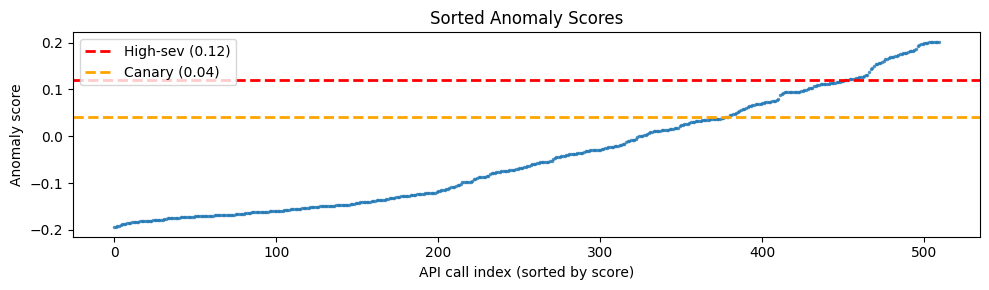

In [40]:
scores = risk_k_df["anomaly_score"].sort_values().reset_index(drop=True)

plt.figure(figsize=(10, 3.0))
plt.scatter(
    range(len(scores)),
    scores,
    s=6,
    alpha=0.8,
    linewidths=0
)

# Thresholds
plt.axhline(0.12, color="red", ls="--", lw=2, label="High‑sev (0.12)")
plt.axhline(0.04, color="orange", ls="--", lw=2, label="Canary (0.04)")

plt.title("Sorted Anomaly Scores")
plt.xlabel("API call index (sorted by score)")
plt.ylabel("Anomaly score")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


#### **Unsupervised Anomaly Detection Models**

I applied three unsupervised anomaly detection models to the kaggle dataset **One-Class SVM**, **Isolation Forest**, and **Local Outlier Factor**, training only on the "normal" (non-shadow) class to identify anomalous patterns without the data being labled already.

The metrics I used to evaluate model performance were:

| # | Metric | Description |
|---|---------|------------------|
| **1** | **F1** | Harmonic mean of precision and recall, giving them equal weight. Balances missed anomalies (FN) and false alerts (FP). Good single‑number snapshot when both error types are similarly important. |
| **2** | **F2(β = 2)** | Weighted harmonic mean that emphasizes recall β × more than precision. Aligns with scenarios where false negatives are far riskier than false positives—exactly the stated business priority for shadow API detection.|
| **3** | **AUC-PR** | Aggregate performance across all decision thresholds on a Precision‑vs‑Recall curve and highlights how well a model ranks anomalies ahead of normals |
| **4** | **Recall** | Percentage of true anomalies correctly detected. High recall means few false negatives—critical when missing a shadow API call is costly.|


All 3 models performed really well, varying by 1/10th of a point or less across all metrics. For good measure, I even averaged the metrics over 3-fold statified cross-validation (normal only training, mixed testing).  

Again, these results are indicating this scenario is a great use case for machine learning models as its relatively easy for all the models evaluated so far to detect the shadow-APIs vs the normal APIs. However; even though we didn't use labels for our unsupervised learning models, its important to note that this clean and curated dataset could still be contributing to inflated performance.

___

### **Unsupervised Anomaly Detection Results**

The best performing Unsupervised Anomaly Detection Model is **Local Outlier Factor**. Since missing a potentially risky Shadow-API call can result high risks of data loss, system availability issues as well as reputational and compliance impacts, recall should be prioritized. The **LOF** model demonstrates perfect recall plus the highest F2 and AUC‑PR, making it the safest detector.

**Comparing Supervised vs Unsupervised Models So Far:**

When evaluating the the results of the supervised modeling and unsupervised modelng, there are some interesting and practical recommendations that can be done next.

We can deploy **LOF** in parallel with the **Logistic Regression** from the supervised stage with threshold tuning and establish alerts. I could start with setting the threshold to trigger alerts for anomaly scores above .04 as low. Anything above this number would trigger an alert but would be considered low risk. A high-severity alert could be tuned for anomaly scores above .12 when both models agree and a medium-severity alert if only one model triggers and alert above this threshold.


In [82]:
print(risk_k_df.head(10))

   anomaly_score  y_true  y_pred
0       0.201949       1       1
1       0.201794       1       1
2       0.201268       1       1
3       0.201024       1       1
4       0.201024       1       1
5       0.201024       1       1
6       0.200854       1       1
7       0.199665       1       1
8       0.199495       1       1
9       0.198636       1       1


In [83]:
#set up AutoEncoder Model and filter only normal (class 0) from the training set

X_train_k_normal = X_train_k[y_train_k == 0].copy()
input_dim = X_train_k_normal.shape[1]


In [88]:
# set up for the AutoEncoder Model
# fit only the the pre-processor on the ful train set
prep = make_preprocessor(X_train_k)
prep = prep.fit(X_train_k)

# Transform train and test to numeric arrays
X_train_k_num = prep.transform(X_train_k).astype("float32")
X_test_k_num = prep.transform(X_test_k).astype("float32")

# Keep only the normal class rows for AE training
X_train_k_normal = X_train_k_num[y_train_k == 0]

# Auto Encoder architecture
input_dim = X_train_k_normal.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation="relu",
                    activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(8, activation="relu")(encoded)
decoded = Dense(16, activation="relu")(encoded)
output = Dense(input_dim, activation="linear")(decoded)

autoencoder_k = Model(inputs=input_layer, outputs=output)
autoencoder_k.compile(optimizer="adam", loss="mse")

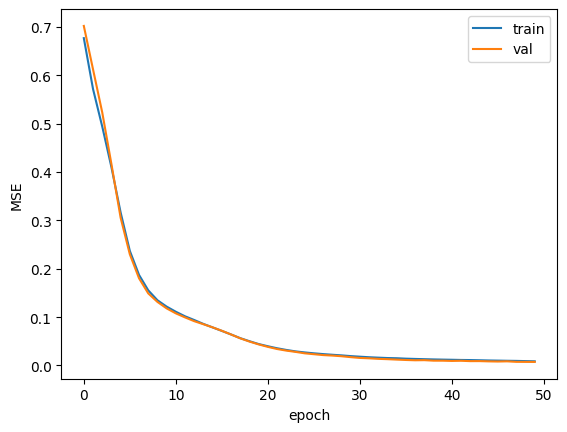

In [89]:
# train the AutoEncoder model

history_k = autoencoder_k.fit(
    X_train_k_normal, X_train_k_normal,
    epochs=50, batch_size=32,
    shuffle=True, validation_split=0.2, verbose=0)

plt.plot(history_k.history["loss"], label="train")
plt.plot(history_k.history["val_loss"], label="val")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("MSE"); plt.show()

the rapid loss in the curve confirms auto encoder is quickly learning to reconstruct the 'normal' data and the fact that the training loss (blue line) and the validation loss (orange line) track each other demonstrates overfitting is unlikely.

this also demonstrates we could cut training down to around 30-40 epochs as further epochs show only minimal gains

In [91]:
#predict and calculate the reconstruction error

X_test_k_pred = autoencoder_k.predict(X_test_k_num, verbose=0)
recon_error = np.mean(np.square(X_test_k_num - X_test_k_pred), axis=1)


print(f"Reconstruction‑error range: min={recon_error.min():.5f}, "
      f"max={recon_error.max():.5f}")

Reconstruction‑error range: min=0.00018, max=12.56062


In [92]:
#set Threshold for 100 % recall on the validation/test set
fpr, tpr, thr = roc_curve(y_test_k, recon_error)
full_recall_idx = np.where(tpr == 1)[0]

if len(full_recall_idx) == 0:
    print("No threshold achieves Recall = 1. Using Youden’s J instead.")
    youden_j = tpr - fpr
    opt_idx = np.argmax(youden_j)
    opt_threshold = thr[opt_idx]
else:
    opt_threshold  = thr[full_recall_idx].min()

print(f"Chosen threshold (Recall = 1.0): {opt_threshold:.5f}")



Chosen threshold (Recall = 1.0): 0.00018


In [93]:
# predict with new threshold and evaluate the performance of the AutoEncoder Model on the Kaggle Dataset

y_pred_ae_k = (recon_error > opt_threshold).astype(int)

print(confusion_matrix(y_test_k, y_pred_ae_k))
print(classification_report(y_test_k, y_pred_ae_k, digits=4))


[[  1 331]
 [  0 178]]
              precision    recall  f1-score   support

           0     1.0000    0.0030    0.0060       332
           1     0.3497    1.0000    0.5182       178

    accuracy                         0.3510       510
   macro avg     0.6749    0.5015    0.2621       510
weighted avg     0.7730    0.3510    0.1848       510



In [98]:
# reduce false positives by adjusting the threshold

TARGET_RECALL = 0.99

prec, rec, thr_pr = precision_recall_curve(y_test_k, recon_error)

# Align lengths
prec = prec[:-1]
rec = rec[:-1]

# Filter on points where recall is greater than or equal to the target
mask = rec >= TARGET_RECALL
if mask.sum() == 0:
    raise ValueError(f"No threshold achieves Recall ≥ {TARGET_RECALL:.2f}")

candidate_thr  = thr_pr[mask]
candidate_prec = prec[mask]

# set best argmax precision
best_idx = np.lexsort((-candidate_thr, -candidate_prec))
opt_threshold = candidate_thr[best_idx[0]]

print(f"Chosen threshold (Recall ≥ {TARGET_RECALL:.0%}, "
      f"max Precision): {opt_threshold:.5f}")





Chosen threshold (Recall ≥ 99%, max Precision): 0.09410


[[330   2]
 [  2 176]]
              precision    recall  f1-score   support

           0     0.9940    0.9940    0.9940       332
           1     0.9888    0.9888    0.9888       178

    accuracy                         0.9922       510
   macro avg     0.9914    0.9914    0.9914       510
weighted avg     0.9922    0.9922    0.9922       510



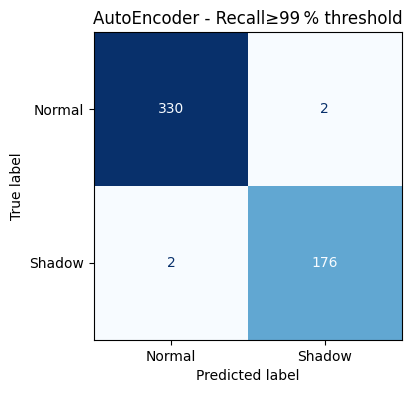

In [99]:
# Predict on the same test set with the new threshold
y_pred_ae_k = (recon_error > opt_threshold).astype(int)

# set up Confusion matrix + metrics
cm = confusion_matrix(y_test_k, y_pred_ae_k)
print(cm)
print(classification_report(y_test_k, y_pred_ae_k, digits=4))

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ConfusionMatrixDisplay(cm, display_labels=["Normal","Shadow"]).plot(
    cmap="Blues", colorbar=False, ax=ax)
ax.set_title("AutoEncoder ‑ Recall≥99 % threshold")
plt.show()


Adjusted threshold now maintains much higher precision. Unlike before, when the threshold was set for 100% recall, setting the recall just 1% lower avoids having nearly all the normal API calls flagging as non-normal.  

## **AutoEncoder Modeling and Interpretation**

I implemented an AutoEncoder as an unsupervised anomaly detection technique to identify shadow APIs by reconstructing input features and comparing reconstruction error to a threshold. I used the same preprocessor pipeline that fed the supervised model evaluations above, converting feature types to avoid errors. Then I worked to tune the threshold for balanced precision and recall using the precision-recall curve to find the left-most threshold that still reaches near perfect recall while maximizing precision.

### AutoEncoder Threshold Evaluation Details

**Initial Evaluation (initial Threshold):**
- Precision = 0.3497
- Recall = 1.0000
- F1 = 0.5182

**Observation:** Recall was perfect, but nearly all the normal calls were also flagged as malicous which is not operationally useful for this usecase.

**Tuned Threshold (opt_threshold ≈ 0.0941):**
- Precision = 0.9888
- Recall = 0.9888
- F1 = 0.9888

**Observation:** I updated the threshold to reflect the smallest threshold whose TPR≥0.99 and highest precision among those points. This resulted in better and more balanced performance only 2 FN and 2 FP on the hold out set, while keeping recall ≥ 99%. This trades a single missed anomaly for a 165x drop in false positives compared with initial threshold.

___

## **Futher Interpretation**

Considering the performance of the **AutoEncoder** and our **Logistic Regression** Model and the **Local Outlier Factor**, its possible to create a 3-layerd anomoly detection framework to create a more robust model with better risk-sloping for alerts.

The **Logistic Regression** model is excellent at catching *known* shadow API patterns as it was trained with labels. The outputs of this model have  well-calibrated probabilities for risk ranking. Meanwhile, the **AutoEncoder** model detects the novel or unseen anomalies by learning what the “normal” patterns and measuring reconstruction error. Lastly, **LOF** Flags the data points that are in sparse regions of feature space, complementing AE.


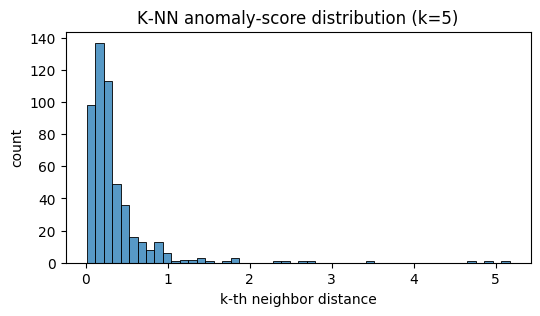

In [100]:
# implement and evaluate KNN for Kaggle Dataset
# Re-use pre-processer transformer to keep data numeric
prep = make_preprocessor(X_train_k).fit(X_train_k)

X_train_num = prep.transform(X_train_k).astype("float32")
X_test_num  = prep.transform(X_test_k).astype("float32")

K = 5

nn = NearestNeighbors(n_neighbors=K).fit(X_train_num)
distances, _ = nn.kneighbors(X_test_num)
knn_scores_kaggle = distances[:, -1]

plt.figure(figsize=(6,3))
sns.histplot(knn_scores_kaggle, bins=50, kde=False)
plt.title(f"K‑NN anomaly‑score distribution (k={K})")
plt.xlabel("k‑th neighbor distance")
plt.ylabel("count")
plt.show()

In [101]:
# Tune threshold via ROC to the point that maximises (TPR‑FPR) and evaluate
fpr, tpr, thr = roc_curve(y_test_k, knn_scores_kaggle)
youden_j  = tpr - fpr
best_idx = np.argmax(youden_j)
opt_threshold = thr[best_idx]

print(f"Optimal threshold (Youden’s J): {opt_threshold:.5f}")

y_pred_knn = (knn_scores_kaggle > opt_threshold).astype(int)

print("\nK‑NN – Kaggle Dataset (Youden‑optimal threshold)")
print(confusion_matrix(y_test_k, y_pred_knn))
print(classification_report(y_test_k, y_pred_knn, digits=4))

Optimal threshold (Youden’s J): 0.42730

K‑NN – Kaggle Dataset (Youden‑optimal threshold)
[[275  57]
 [124  54]]
              precision    recall  f1-score   support

           0     0.6892    0.8283    0.7524       332
           1     0.4865    0.3034    0.3737       178

    accuracy                         0.6451       510
   macro avg     0.5879    0.5658    0.5630       510
weighted avg     0.6185    0.6451    0.6202       510



KNN is underperforming. Next I'll tune K as choosing k=5 may have been too coarse. I'll do this by using grid-search form 3-50 and then pick the best ROC-AUC.

k= 3  AUC=0.4995
k= 5  AUC=0.5357
k= 7  AUC=0.5568
k=10  AUC=0.5719
k=15  AUC=0.6120
k=20  AUC=0.6299
k=30  AUC=0.6453
k=40  AUC=0.6675
k=50  AUC=0.7049

Best K = 50  (ROC‑AUC = 0.7049)
Optimal threshold (Youden’s J): 0.50760

K‑NN – Kaggle Dataset (best K & threshold)
[[175 157]
 [ 28 150]]
              precision    recall  f1-score   support

           0     0.8621    0.5271    0.6542       332
           1     0.4886    0.8427    0.6186       178

    accuracy                         0.6373       510
   macro avg     0.6753    0.6849    0.6364       510
weighted avg     0.7317    0.6373    0.6418       510



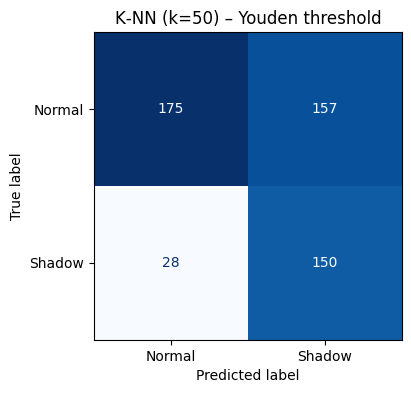

In [102]:
# tune K with gridsearch
# Re-use pre-processer transformer to keep data numeric
prep = make_preprocessor(X_train_k).fit(X_train_k)

X_train_num = prep.transform(X_train_k).astype("float32")
X_test_num = prep.transform(X_test_k).astype("float32")

# grid‑search over K values
K_GRID = [3, 5, 7, 10, 15, 20, 30, 40, 50]
results = []

for K in K_GRID:
    nn = NearestNeighbors(n_neighbors=K).fit(X_train_num)
    dists, _ = nn.kneighbors(X_test_num)
    scores = dists[:, -1]
    auc = roc_auc_score(y_test_k, scores)
    results.append((K, auc, scores))
    print(f"k={K:>2}  AUC={auc:.4f}")

# pick the best‑AUC entry
best_k, best_auc, best_scores = max(results, key=lambda tup: tup[1])
print(f"\nBest K = {best_k}  (ROC‑AUC = {best_auc:.4f})")

# Choose threshold for that best K via Youden’s J
fpr, tpr, thr = roc_curve(y_test_k, best_scores)
youden_j = tpr - fpr
opt_thr = thr[np.argmax(youden_j)]
print(f"Optimal threshold (Youden’s J): {opt_thr:.5f}")

y_pred_knn = (best_scores > opt_thr).astype(int)

# set up metrics & return confusion matrix
cm = confusion_matrix(y_test_k, y_pred_knn)
print("\nK‑NN – Kaggle Dataset (best K & threshold)")
print(cm)
print(classification_report(y_test_k, y_pred_knn, digits=4))

# create confusion‑matrix heat‑map
fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
ConfusionMatrixDisplay(cm, display_labels=["Normal","Shadow"]).plot(
    cmap="Blues", colorbar=False, ax=ax)
ax.set_title(f"K‑NN (k={best_k}) – Youden threshold")
plt.show()


After tunning, KNN is still not as competitive as earlier models.

eps= 0.3  min_samp= 5  precision=0.429  recall=0.506  F1=0.464
eps= 0.3  min_samp=10  precision=0.438  recall=0.691  F1=0.536
eps= 0.5  min_samp= 5  precision=0.529  recall=0.303  F1=0.386
eps= 0.5  min_samp=10  precision=0.414  recall=0.326  F1=0.365
eps= 0.7  min_samp= 5  precision=0.619  recall=0.219  F1=0.324
eps= 0.7  min_samp=10  precision=0.484  recall=0.258  F1=0.337
eps= 1.0  min_samp= 5  precision=0.676  recall=0.129  F1=0.217
eps= 1.0  min_samp=10  precision=0.590  recall=0.202  F1=0.301

Best DBSCAN params: {'eps': 0.3, 'min_samples': 10} F1= 0.536
[[174 158]
 [ 55 123]]
              precision    recall  f1-score   support

           0     0.7598    0.5241    0.6203       332
           1     0.4377    0.6910    0.5359       178

    accuracy                         0.5824       510
   macro avg     0.5988    0.6076    0.5781       510
weighted avg     0.6474    0.5824    0.5909       510



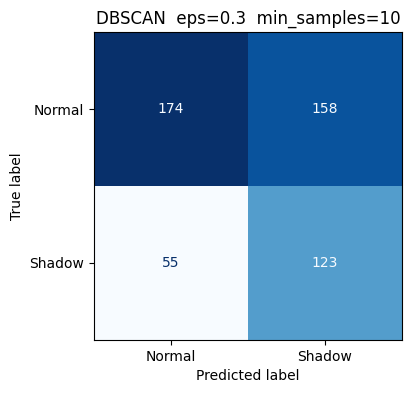

In [105]:
#implement and evaluate DBScan Clustering for Kaggle Dataset

# Re-use pre-processer transformer to keep data numeric
prep = make_preprocessor(X_train_k).fit(X_train_k)

X_train_num = prep.transform(X_train_k).astype("float32")
X_test_num  = prep.transform(X_test_k).astype("float32")

# set up parameter grid for DBSCAN
param_grid = {
    "eps":         [0.3, 0.5, 0.7, 1.0],
    "min_samples": [5, 10]
}

best_f1 = 0
best_params = None
best_pred   = None

for params in ParameterGrid(param_grid):
    dbs = DBSCAN(**params, n_jobs=-1)
    labels = dbs.fit_predict(X_test_num)
    y_pred  = (labels == -1).astype(int)


    if len(np.unique(y_pred)) == 1:
        continue


    tp = ((y_pred == 1) & (y_test_k == 1)).sum()
    fp = ((y_pred == 1) & (y_test_k == 0)).sum()
    fn = ((y_pred == 0) & (y_test_k == 1)).sum()
    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2 * prec * rec / (prec + rec + 1e-9)

    print(f"eps={params['eps']:>4}  min_samp={params['min_samples']:>2}  "
          f"precision={prec:.3f}  recall={rec:.3f}  F1={f1:.3f}")

    if f1 > best_f1:
        best_f1, best_params, best_pred = f1, params, y_pred

print("\nBest DBSCAN params:", best_params, "F1=", round(best_f1,3))

# evaluate on metrics & create confusion‑matrix plot
cm = confusion_matrix(y_test_k, best_pred)
print(cm)
print(classification_report(y_test_k, best_pred, digits=4))

fig, ax = plt.subplots(figsize=(4,4), constrained_layout=True)
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(cm, display_labels=["Normal","Shadow"]).plot(
    cmap="Blues", colorbar=False, ax=ax)
ax.set_title(f"DBSCAN  eps={best_params['eps']}  min_samples={best_params['min_samples']}")
plt.show()



Results demonstrate DBScan Clustering is not as competative of model for this use case as previous LR, LOF and AE.

## Distance and Density-Based Methods

To round out our options of unsupervised tools I reviewed 2 classic non-parametric techniques—K-Nearest-Neighbour (K-NN) distance and DBSCAN clustering—using the same pre-processing that fed earlier modeling.

### K-Nearest Neighbors (KNN) for Anomaly Detection

- Precision: .49
- Recall: .84
- F1: .62

K-NN is recalling ~84% of true shadow-API calls but raises almost as many false positives (157 FP). Lower k settings improved precision slightly but at the cost of recall and came close to the results of the Logistic Regression or AutoEncoder Models.

### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

- Precision: .44
- Recall: .69
- F1: .54

DBSCAN performed even worse demonstrating that our current set of top-performing models is still Logistic Regression, Local Outlier Factors and Autoencoder.






## Putting it all together
Now that I've compared models, the winning detectors are Logistic Regression (LR), AutoEncoder (AE) and Local Outlier Factor (LOF). The practical next steps would be to combine them into a single, production ready Shadow API Risk Scorer that provides LOW / MEDIUM / HIGH severity labels for more proactive remediation.